# Training a better model

This week, we want to improve on the model we have trained from last week from a underfitting or overfitting perspective.

In [1]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [2]:
from importlib import reload
import utils; reload(utils)
from utils import *
from __future__ import division, print_function
%matplotlib inline

Using Theano backend.


In [3]:
path = 'data/dogscats/'
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
    
batch_size=64

## Are we underfitting?

So far, our validation accuracy has generally been higher that our training accuracy
This leads to 2 questions:
1. How is this possible?
2. Is this desirable?

**Answer 1):**
Because of _dropout_. Dropout refers to a layer taht randomly deletes (i.e. sets to 0) each activation in the previous layer with probability _p_ (usually 0.5). This only happends during training, not when calculating the accuracy on the validation set, which is why the validation set can have higher accuracy than the training set.

The purpose of dropout is to avoid overfitting. Why? -- by deleting parts of the neural netowkr at random during training, it ensures that no one part of the network can overfit to one part of the training set. The creation of dropout was one of the key developments in deep learning, which allows us to create rich models w/o overfitting. However, it can also result in underfitting if overused. 

**Answer 2):**
Not desirable. It is likely that we can get better validation set results with less dropout.

### Removing dropout

We start with our fine-tuned cats vs dogs model (with dropout), then fine-tune again all the dense layers, after removing dropout from them.

Action Plan:
* Re-create and load our modified VGG model with binary dependent
* Split the model between the convolutnional (_conv_) layers and the dense layers
* Pre-calculate the output of the conv layers, so that we don't have to redundently re-calculate them on every epoch
* Create a new model with just the dense layers and dropout p set to 0
* Train this new model using the output of the conv layers as training data

In [4]:
??vgg_ft

```py
def vgg_ft(out_dim):
    vgg = Vgg16()
    vgg.ft(out_fim)
    model = vgg.model
    return model
```

In [5]:
??Vgg16.ft

```py
def ft(self, num):
    """
    Replace the last layer of the model with a Dense layer of num neurons.
    Will also lock the weights of all layers except the new layer so that we only learn weights for the last layer in subsequent training.
    Args:
        num (int): Number of neurons in the Dense layer
    Returns:
        None
"""
    model = self.model
    model.pop()
    for layer in model.layers: layer.trainable=False
    model.add(Dense(num, activation='softmax'))
    self.compile()
```

In [4]:
model = vgg_ft(2)

...and load our fine-tuned weights from lesson 2.

In [5]:
model.load_weights(model_path + 'finetune3.h5')

Now, let's train a few iterations w/o dropout. But first, let's pre-calculate the input to the fully connected layers - i.e. the _Flatten()_ layer.

Because convolution layers take a lot of time to compute, but Dense layers do not.

In [13]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [6]:
layers = model.layers

In [7]:
# find the lasy convolution layer
last_conv_idx = [index for index, layer in enumerate(layers) 
                 if type(layer) is Convolution2D][-1]
last_conv_idx

30

In [8]:
layers[last_conv_idx]

In [9]:
conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
fc_layers = layers[last_conv_idx+1:]

Now, we can use the exact same approach to create features as we used when we created the linear model from the imagenet predictions in lesson 2.

In [47]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
# Let's get the outputs of the conv model and save them
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)
trn_features = conv_model.predict_generator(batches, batches.nb_sample)

In [ ]:
save_array(model_path + 'train_convlayer_features.bc', trn_features)
save_array(model_path + 'valid_convlayer_features.bc', val_features)

In [45]:
trn_features = load_array(model_path+'train_convlayer_features.bc')
val_features = load_array(model_path+'valid_convlayer_features.bc')

In [16]:
trn_features.shape
# Note that the last conv layer is 512, 14, 14

(23000, 512, 14, 14)

For our new fully connected model, we'll create it using the exact same architecture as the last layers of VGG 16, so that we can conveniently copy pre-trained weights over from that model. 

In [13]:
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [14]:
# Such a finely tuned model needs to be updated very slowly!!
opt = RMSprop(lr=0.00001, rho=0.7)

In [15]:
def get_fc_model():
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
        ])
    
    for l1, l2 in zip(model.layers, fc_layers): l1.set_weights(proc_wgts(l2))
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
fc_model = get_fc_model()

And fit the model in the usual way:

In [23]:
fc_model.fit(trn_features, trn_labels, nb_epoch=8,
            batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 61s - loss: 0.2696 - acc: 0.9807 - val_loss: 0.2352 - val_acc: 0.9850
Epoch 2/8
23000/23000 [==============================] - 62s - loss: 0.1891 - acc: 0.9865 - val_loss: 0.2028 - val_acc: 0.9855
Epoch 3/8
23000/23000 [==============================] - 62s - loss: 0.1508 - acc: 0.9895 - val_loss: 0.1819 - val_acc: 0.9865
Epoch 4/8
23000/23000 [==============================] - 62s - loss: 0.1317 - acc: 0.9913 - val_loss: 0.2270 - val_acc: 0.9845
Epoch 5/8
23000/23000 [==============================] - 62s - loss: 0.1227 - acc: 0.9918 - val_loss: 0.2178 - val_acc: 0.9845
Epoch 6/8
23000/23000 [==============================] - 61s - loss: 0.1069 - acc: 0.9928 - val_loss: 0.2066 - val_acc: 0.9865
Epoch 7/8
23000/23000 [==============================] - 61s - loss: 0.1056 - acc: 0.9929 - val_loss: 0.1955 - val_acc: 0.9865
Epoch 8/8
23000/23000 [==============================] - 61s -

In [24]:
fc_model.save_weights(model_path+'no_dropout.h5')

In [17]:
fc_model.load_weights(model_path+'no_dropout.h5')

## Reducing overfitting

Now we've gotten a model that overfits. So let's take a few steps to reduce this.

### Approaches to reduce overfitting

Before relying on dropout or other regularization approches to reduce overfitting, try the following techniques first. Because regularization, by definition, biases our model towards simplicity - which we only wnat to do if we know that's necessary. 

Action Plan:
1. Add more data (Kaggle comp N.A.)
2. Use data augmentation
3. Use architectures that generalize well
4. Add regularization
5. Reduce architecture complexity

We assume that you've already collected as much data as you can ,so step (1) isn't relevant. 


### Data augmentation

Step 2 - Data augmentation refers to creating additional synthetic data, based on reasonable modifications of your input data. For images, this is likely to involve flipping, rotation, zooming, cropping, panning, minor color changes ...

Which types of augmentation are appropriate depends on your data. For instance, for regular photots, you want to use hotizontal flipping, but not vertical flipping. We recommand **always** using at least some light data aumentation, unless you have so much data that your model will never see the same input twice.

Keras comes with very convenient features for automating data augmentation. You simply define what types and maximum amount of augementation you want.

In [18]:
# dim_ordering='tf' uses tensorflow dimension ordering,
#   which is the same order as matplotlib uses for display.
# Therefore when just using for display purposes, this is more convenient
gen = image.ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1,height_shift_range=0.1,
    shear_range=0.15, zoom_range=0.1, channel_shift_range=10., horizontal_flip=True,
    dim_ordering='tf')

So to decide which augmentation methods to use, let's take a look at the generated imaged, and use our intuition.

In [20]:
# Create a 'batch' of a single image
img = np.expand_dims(ndimage.imread('data/dogscats/test/unknown/7.jpg'),0)
# Request the generator to create batches from this image
aug_iter = gen.flow(img)

In [21]:
# Get 8 examples of these augmentated images
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

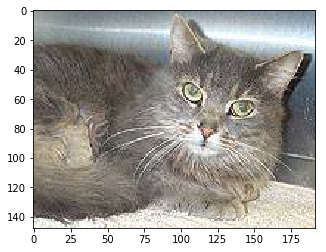

In [22]:
# The original
plt.imshow(img[0])

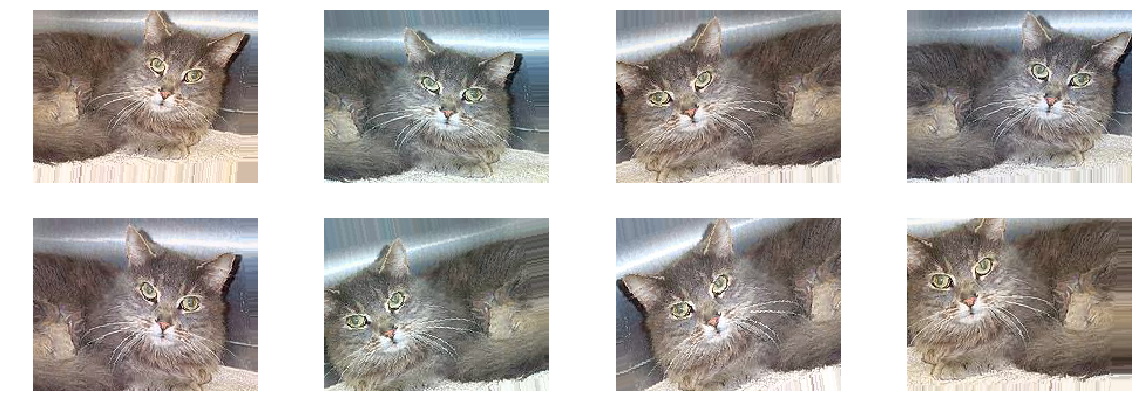

In [23]:
# Augmented
plots(aug_imgs, (20, 7), 2)

In [24]:
# Ensure that we return to theano dimension ordering
K.set_image_dim_ordering('th')

Now, it's time to add a small amount of data augmentation, and see if we can reduce overfitting. The approach will be identical to the method we used to finetune the dense layers in lesson2, except that will use a generator with augmentation configured. Here's how we set up the generator and create batches from it:

In [26]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1,height_shift_range=0.1,
                               zoom_range=0.1,horizontal_flip=True)
batches = get_batches(path+'train', gen, batch_size=batch_size)
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [25]:
??get_batches

```py
get_batches(dirname, gen=<keras.preprocessing.image.ImageDataGenerator object at 0x7fb1a30544e0>, shuffle=True, batch_size=4, class_mode='categorical', target_size=(224, 224))
```

When using data augmentation, we can't pre-compute our convolutional layer features, since randomized changes are being made to every input image (--> the result of the conv layers will be different).

Therefore, in order to allow data to flow through all the conv layers and our new dense layers, we attach our fully connected model to the conv model -- after ensuring that the conv layers are not trainable.

In [29]:
fc_model = get_fc_model()
for layer in conv_model.layers: layer.trainable = False
conv_model.add(fc_model)

IndexError: tuple index out of range

Now, we can compile, train, and save our model as usual - note we use _fit_generator()_ since we want to pull random images from the directories on every batch

In [30]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/3
23000/23000 [==============================] - 641s - loss: 0.3461 - acc: 0.9743 - val_loss: 0.2707 - val_acc: 0.9810
Epoch 2/3
23000/23000 [==============================] - 641s - loss: 0.3402 - acc: 0.9754 - val_loss: 0.2707 - val_acc: 0.9810
Epoch 3/3
23000/23000 [==============================] - 642s - loss: 0.3254 - acc: 0.9764 - val_loss: 0.2707 - val_acc: 0.9810


In [34]:
conv_model.save_weights(model_path + 'aug1.h5')

In [ ]:
conv_model.load_weights(model_path + 'aug1.h5')

### Batch normalization

Batch normalization is a way to ensure that activations don't become too high or too low at any point in the model. Adjusting activiations so that are of similar scales is called **normalization**. It is very helpful for fast training - if some activations are very high, they will saturate the model and create very large gradients, causing training to fail; if very low, they will cause training to proceed very slowly.

Prior to the developement of batchnorm in 2015, only the inputs to a model could be effectively normalized. However, weights in intermediate layers could easily become poorly scaled, due to problems in weight initialization, or a high learning rate combined with random fluctuations in weights.

Batchnorm resolves this problem by normalizing each intermediate layer as well. The details of how it works are not terribly important - the important takeaway is: **all modern networks should use batchnorm, or something equivalent**.

2 reasons for this:
1. Adding batchnorm to a model can result in **10x or more improvements in training speed**
2. Normalization greatly reduces the ability of a small number of outlying inputs to over-influence the training. It also tends to **reduce overfitting**

_How it works:_

At a first step, it normalizes intermediate layers (activations) in the same way as input layers can be normalized. But this would not be enough, since the model would then just push the weights up or down indefinitely to try to undo this normalization. So, there are 2 additional steps:
1. Add 2 more trainable parameters to each layer - one to multiply all activations to set an arbitrary standard deviation, and one to add to all activations to set an arbitraty mean
2. Incorporate both the normalization, and the learnt multiply/add parameters, into the gradient calcultions during backprop.

This ensures that the weights don't tend to push very high or very low (since the normalization is included in the gradient calculations, so the updates are aware of the normalization). But it also ensures that if a layer does need to change the overall mean or standard deviation in order to match the output scale, it can do so.

#### Adding batchnorm to the model
Why VGG does not use this? Because then VGG was created, batchnorm has not been invented.

In [35]:
conv_layers[-1].output_shape[1:]

(512, 14, 14)

In [37]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1000, activation='softmax')
    ]

In [38]:
def load_fc_weights_from_vgg16bn(model):
    "Load weights for model from the dense layers of the VGG16BN model."
    # See imagenet_batchnorm.ipynb for info on how the weights for
    # Vgg16BN can be generated from the standard Vgg16 weights.
    from vgg16bn import Vgg16BN
    vgg16_bn = Vgg16BN()
    _, fc_layers = split_at(vgg16_bn.model, Convolution2D)
    copy_weights(fc_layers, model.layers)

In [39]:
p = 0.6
bn_model = Sequential(get_bn_layers(0.6))

In [40]:
load_fc_weights_from_vgg16bn(bn_model)

553615360/553620808 [============================>.] - ETA: 0s

In [41]:
def proc_wgts(layer, prev_p, new_p):
    scal = (1-prev_p)/(1-new_p)
    return [o*scal for o in layer.get_weights()]

for l in bn_model.layers: 
    if type(l)==Dense: l.set_weights(proc_wgts(l, 0.5, 0.6))

In [42]:
bn_model.pop()
for layer in bn_model.layers: layer.trainable=False

In [43]:
bn_model.add(Dense(2, activation='softmax'))
bn_model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [48]:
bn_model.fit(trn_features, trn_labels, nb_epoch=8, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 14s - loss: 0.2930 - acc: 0.9514 - val_loss: 0.0908 - val_acc: 0.9840
Epoch 2/8
23000/23000 [==============================] - 13s - loss: 0.3188 - acc: 0.9581 - val_loss: 0.1052 - val_acc: 0.9835
Epoch 3/8
23000/23000 [==============================] - 13s - loss: 0.3313 - acc: 0.9605 - val_loss: 0.1183 - val_acc: 0.9850
Epoch 4/8
23000/23000 [==============================] - 13s - loss: 0.3479 - acc: 0.9616 - val_loss: 0.1203 - val_acc: 0.9840
Epoch 5/8
23000/23000 [==============================] - 13s - loss: 0.3693 - acc: 0.9609 - val_loss: 0.1347 - val_acc: 0.9830
Epoch 6/8
23000/23000 [==============================] - 14s - loss: 0.3449 - acc: 0.9641 - val_loss: 0.1166 - val_acc: 0.9850
Epoch 7/8
23000/23000 [==============================] - 14s - loss: 0.3593 - acc: 0.9661 - val_loss: 0.1262 - val_acc: 0.9840
Epoch 8/8
23000/23000 [==============================] - 14s -

In [49]:
bn_model.save_weights(model_path+'bn.h5')

In [ ]:
bn_model.load_weights(model_path+'bn.h5')

In [51]:
bn_layers = get_bn_layers(0.6)
bn_layers.pop()
bn_layers.append(Dense(2, activation='softmax'))

final_model = Sequential(conv_layers)
for layer in final_model.layers: layer.trainable = False
for layer in bn_layers: final_model.add(layer)

In [52]:
for l1, l2 in zip(bn_model.layers, bn_layers):
    l2.set_weights(l1.get_weights())
    

In [53]:
final_model.compile(optimizer=Adam(), 
                    loss='categorical_crossentropy', metrics=['accuracy'])
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
23000/23000 [==============================] - 673s - loss: 5.6826 - acc: 0.6374 - val_loss: 11.7105 - val_acc: 0.2630


In [ ]:
final_model.save_weights(model_path + 'final1.h5')

In [ ]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=4, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
final_model.save_weights(model_path + 'final2.h5')
# you can try to set final_model.optimizer.lr=0.001 and try another model